<a href="https://colab.research.google.com/github/Sahabat-Gula-C242-PS390/Machine-Learning/blob/main/fd_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import zipfile
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.python.keras.utils.vis_utils import plot_model

In [ ]:
import os
import shutil

# Define source folders
folders_to_copy = [
    "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/train",
    "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/val",
    "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/test"
]

# Define destination folder
train_2_folder = "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/train_2"

# Check if the destination folder already contains files
if any(os.scandir(train_2_folder)):
    print("Destination folder already contains files. Skipping copy.")
else:
    # Create the destination folder if it doesn't exist
    os.makedirs(train_2_folder, exist_ok=True)

    # Copy files if the destination folder is empty
    for folder in folders_to_copy:
        for root, dirs, files in os.walk(folder):
            for file in files:
                src = os.path.join(root, file)
                # Determine relative path and create corresponding subfolder in train_2
                relative_path = os.path.relpath(root, folder)
                dest_folder = os.path.join(train_2_folder, relative_path)
                os.makedirs(dest_folder, exist_ok=True)
                dest = os.path.join(dest_folder, file)
                shutil.copy2(src, dest)

    print("All files have been copied to train_2.")


All files have been copied to train_2.


In [ ]:
import os
import shutil
import random

# Define the paths
train_folder = "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/train_2"
val_folder = "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/val_2"
test_folder = "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/test_2"

# Check if validation and test folders already contain files
def is_already_split(folder):
    return any(os.path.isfile(os.path.join(folder, f)) for f in os.listdir(folder))

# Prevent splitting if already split
if is_already_split(val_folder) or is_already_split(test_folder):
    print("Data already split. Skipping.")
else:
    # Create val and test folders if they do not exist
    os.makedirs(val_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Iterate over each food subdirectory in the train folder
    for food in os.listdir(train_folder):
        food_train_folder = os.path.join(train_folder, food)

        if os.path.isdir(food_train_folder):
            # Create corresponding folders in val and test
            food_val_folder = os.path.join(val_folder, food)
            food_test_folder = os.path.join(test_folder, food)
            os.makedirs(food_val_folder, exist_ok=True)
            os.makedirs(food_test_folder, exist_ok=True)

            # Get all image files in the food folder
            image_files = [f for f in os.listdir(food_train_folder) if os.path.isfile(os.path.join(food_train_folder, f))]
            num_images = len(image_files)

            # Check if there are enough files to split
            if num_images >= 10:
                # Shuffle the image list
                random.shuffle(image_files)

                # Split the images into val (10%) and test (10%)
                num_val = int(num_images * 0.1)
                num_test = int(num_images * 0.1)

                # Move the images to the appropriate folders
                for i, image in enumerate(image_files):
                    src = os.path.join(food_train_folder, image)

                    if i < num_val:
                        shutil.move(src, os.path.join(food_val_folder, image))
                    elif i < num_val + num_test:
                        shutil.move(src, os.path.join(food_test_folder, image))

    print("Data splitting completed.")


In [ ]:
train_folder = "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/train_2"
val_folder = "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/val_2"
test_folder = "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/test_2"

val_dir = val_folder
train_dir = train_folder
labels = [name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))]
print(labels)

['Indomie-Kari-Ayam-72g', 'ABC-Kopi-Susu-30g', 'Ultra-Milk-Coklat-125ml', 'Indomie-Soto-72g', 'Indomie-Goreng-72g', 'Teh-Kotak-Original-200ml', 'Good-Day-Mocacinno-20g', 'Good-Day-Cappuccino-25g', 'Kapal-Api-Signature-25g', 'Sari-Gandum-Sandwich-Susu-Cokelat-27g', 'Energen-Cokelat-34g', 'Energen-Vanila-34g', 'Nabati-Coklat-37g', 'Superstar-Chocolate-16g', 'Nutrisari-Sweet-Orange-14g', 'Tango-Royal-Chocolate-35g', 'Indocafe-Coffeemix-20g', 'Nabati-Keju-37g', 'Luwak-White-Coffee-20g', 'Indomilk-Kids-Cokelat-115ml']


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
    # Instantiate the ImageDataGenerator class
    # normalize pixel values and set arguments to augment the images
    train_datagen = ImageDataGenerator( rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        brightness_range=[0.7, 1.3],
                                        fill_mode='nearest')


    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    # Remember that validation data should not be augmented
    validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                    batch_size=32,
                                                                    class_mode='categorical',
                                                                    target_size=(224, 224))

    testing_datagen = ImageDataGenerator(rescale = 1.0/255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    testing_generator = validation_datagen.flow_from_directory(directory='/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/test_2',
                                                                    batch_size=32,
                                                                    class_mode='categorical',
                                                                    target_size=(224, 224))

    return train_generator, validation_generator, testing_generator

In [ ]:
train_generator, validation_generator, testing_generator = train_val_generators(train_dir, val_dir, '/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/test_2')


Found 814 images belonging to 20 classes.
Found 94 images belonging to 20 classes.
Found 92 images belonging to 20 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
pre_trained_model = MobileNetV2(input_shape = (224, 224, 3),
                                  include_top = False,
                                  weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 2,257,984 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:
output = pre_trained_model.output
print(output)

<KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_153>


In [ ]:
def create_final_model(pre_trained_model):
    output = pre_trained_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(output)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    predictions = tf.keras.layers.Dense(20, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

    # Compile the model
    # Define a lower learning rate (e.g., 1e-5 for slower learning)
    optimizer = Adam(learning_rate=1e-5)

    # Compile the model with the modified learning rate
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Save model in a variable
model = create_final_model(pre_trained_model)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 4,922,452 total parameters in this model.
There are 2,664,468 trainable parameters in this model.


In [ ]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,922,452 (18.78 MB)

 Trainable params: 2,664,468 (10.16 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the directory to save checkpoints and plots
checkpoint_dir = "/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2"
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the custom callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') > 0.91 and logs.get('accuracy') > 0.91 and logs.get('loss') < 0.5):
            print("\n Stop Training because accuracy is more than 90.0% and loss is less than 0.5")
            self.model.stop_training = True

# Create the checkpoint callback to save the model with the best validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model_2.keras"),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Create the History callback to save training history
history_callback = myCallback()

# Define a function to save training history as a plot
def save_history_plot(history, plot_dir=checkpoint_dir):
    # Plot accuracy and loss
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Save the plot
    plot_path = os.path.join(plot_dir, 'training_history.png')
    plt.savefig(plot_path)
    plt.close()

# Define the list of callbacks
callbacks = [checkpoint_callback, history_callback]

# Training the model with the callbacks

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 50,
                    verbose = 1,
                    callbacks=callbacks
)

# After training, save the history plot
save_history_plot(history)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0679 - loss: 3.1341
Epoch 1: val_accuracy improved from -inf to 0.15957, saving model to /content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/best_model_2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 234s 7s/step - accuracy: 0.0687 - loss: 3.1311 - val_accuracy: 0.1596 - val_loss: 2.8570
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1385 - loss: 2.8102
Epoch 2: val_accuracy improved from 0.15957 to 0.27660, saving model to /content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/best_model_2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 192s 6s/step - accuracy: 0.1393 - loss: 2.8092 - val_accuracy: 0.2766 - val_loss: 2.6417
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2074 - loss: 2.6419
Epoch 3: val_accuracy improved from 0.27660 to 0.39362, saving model to /content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/best_model_2.keras
26/26 ━━

In [ ]:
import pandas as pd

# Assuming 'history' is the dictionary containing training history
hist_df = pd.DataFrame(history.history)

# Save to JSON
hist_df.to_json('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history_mobilenetv2_valacc_0.9194.json')

# Or save to CSV
hist_df.to_csv('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history_mobilenetv2_valacc_0.9194.csv')

In [ ]:
# Reinitialize the optimizer
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define a new callback
new_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model_2.keras"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Define a new custom callback
class EarlyStoppingByLoss(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') < 0.3:
            print("\nStop Training: Loss is below 0.3")
            self.model.stop_training = True


# Define a function to save training history as a plot
def save_history_plot(history, plot_dir=checkpoint_dir):
    # Plot accuracy and loss
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Save the plot
    plot_path = os.path.join(plot_dir, 'training_history_2.png')
    plt.savefig(plot_path)
    plt.close()


model.compile(
    optimizer=Adam(learning_rate=0.001),  # Use your preferred optimizer settings
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Update the callbacks list
new_callbacks = [new_checkpoint_callback, EarlyStoppingByLoss()]

# Continue training with new callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Additional epochs
    verbose=1,
    callbacks=new_callbacks
)

save_history_plot(history)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6947 - loss: 1.4195
Epoch 1: val_loss improved from inf to 0.18733, saving model to /content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/best_model_2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 210s 6s/step - accuracy: 0.6973 - loss: 1.4033 - val_accuracy: 0.9574 - val_loss: 0.1873
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9233 - loss: 0.2712
Epoch 2: val_loss improved from 0.18733 to 0.04967, saving model to /content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/best_model_2.keras

Stop Training: Loss is below 0.3
26/26 ━━━━━━━━━━━━━━━━━━━━ 256s 6s/step - accuracy: 0.9236 - loss: 0.2697 - val_accuracy: 0.9894 - val_loss: 0.0497


In [ ]:
import pandas as pd

# Assuming 'history' is the dictionary containing training history
hist_df = pd.DataFrame(history.history)

# Save to JSON
hist_df.to_json('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history2_mobilenetv2_valacc_0.9194.json')

# Or save to CSV
hist_df.to_csv('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history2_mobilenetv2_valacc_0.9194.csv')

In [ ]:
# Reinitialize the optimizer
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define a new callback
new_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model_2.keras"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Define a new custom callback
class EarlyStoppingByLoss(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') < 0.1:
            print("\nStop Training: Loss is below 0.3")
            self.model.stop_training = True


# Define a function to save training history as a plot
def save_history_plot(history, plot_dir=checkpoint_dir):
    # Plot accuracy and loss
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Save the plot
    plot_path = os.path.join(plot_dir, 'training_history_3.png')
    plt.savefig(plot_path)
    plt.close()


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Update the callbacks list
new_callbacks = [new_checkpoint_callback, EarlyStoppingByLoss()]

# Continue training with new callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Additional epochs
    verbose=1,
    callbacks=new_callbacks
)

save_history_plot(history)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8946 - loss: 0.3998
Epoch 1: val_loss improved from inf to 0.30526, saving model to /content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/best_model_2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 207s 6s/step - accuracy: 0.8944 - loss: 0.4002 - val_accuracy: 0.8830 - val_loss: 0.3053
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9492 - loss: 0.1985
Epoch 2: val_loss improved from 0.30526 to 0.08832, saving model to /content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/best_model_2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step - accuracy: 0.9497 - loss: 0.1960 - val_accuracy: 0.9894 - val_loss: 0.0883
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0555
Epoch 3: val_loss did not improve from 0.08832

Stop Training: Loss is below 0.3
26/26 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.9833 - loss: 0.0563 - val_accuracy: 0.9681 - v

In [ ]:
import pandas as pd

# Assuming 'history' is the dictionary containing training history
hist_df = pd.DataFrame(history.history)

# Save to JSON
hist_df.to_json('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history3_mobilenetv2_valacc_0.9194.json')

# Or save to CSV
hist_df.to_csv('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history3_mobilenetv2_valacc_0.9194.csv')

In [ ]:
# Reinitialize the optimizer
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define a new callback
new_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model_2.keras"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Define a new custom callback
class EarlyStoppingByLoss(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') < 0.01:
            print("\nStop Training: Loss is below 0.01")
            self.model.stop_training = True


# Define a function to save training history as a plot
def save_history_plot(history, plot_dir=checkpoint_dir):
    # Plot accuracy and loss
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Save the plot
    plot_path = os.path.join(plot_dir, 'training_history_4.png')
    plt.savefig(plot_path)
    plt.close()


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Update the callbacks list
new_callbacks = [new_checkpoint_callback, EarlyStoppingByLoss()]

# Continue training with new callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Additional epochs
    verbose=1,
    callbacks=new_callbacks
)

save_history_plot(history)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9418 - loss: 0.2200
Epoch 1: val_loss improved from inf to 0.06363, saving model to /content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/best_model_2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 210s 6s/step - accuracy: 0.9421 - loss: 0.2182 - val_accuracy: 0.9894 - val_loss: 0.0636
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9631 - loss: 0.1037
Epoch 2: val_loss did not improve from 0.06363
26/26 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.9630 - loss: 0.1039 - val_accuracy: 0.9468 - val_loss: 0.1601
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9795 - loss: 0.0695
Epoch 3: val_loss did not improve from 0.06363
26/26 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.9792 - loss: 0.0708 - val_accuracy: 0.9681 - val_loss: 0.0983
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9625 - loss: 0.1449
Epoch 4: val_loss did not improve from 0.06363
26/26 ━━━━━━

KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Assuming 'history' is the dictionary containing training history
hist_df = pd.DataFrame(history.history)

# Save to JSON
hist_df.to_json('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history4_mobilenetv2_valacc_0.9194.json')

# Or save to CSV
hist_df.to_csv('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history4_mobilenetv2_valacc_0.9194.csv')

In [ ]:
# Combine history

import pandas as pd
import os
import json

# Define file paths
folder = '/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2'
csv_files = [
    "history_mobilenetv2_valacc_0.9194.csv",
    "history2_mobilenetv2_valacc_0.9194.csv",
    "history3_mobilenetv2_valacc_0.9194.csv",
    "history4_mobilenetv2_valacc_0.9194.csv"
]

# Combine CSV files
csv_dataframes = [pd.read_csv(os.path.join(folder, file)) for file in csv_files]
combined_csv = pd.concat(csv_dataframes, ignore_index=True)

# Save combined CSV
csv_output = os.path.join(folder, "history_final_mobilenetv2_valacc_0.9194.csv")
combined_csv.to_csv(csv_output, index=False)

# Combine JSON files
json_files = [
    "history_mobilenetv2_valacc_0.9194.json",
    "history2_mobilenetv2_valacc_0.9194.json",
    "history3_mobilenetv2_valacc_0.9194.json",
    "history4_mobilenetv2_valacc_0.9194.json"
]

# Combine JSON files
combined_json_data = {}

for file in json_files:
    json_path = os.path.join(folder, file)
    with open(json_path, 'r') as f:
        data = json.load(f)
        for key, value in data.items():
            if key not in combined_json_data:
                combined_json_data[key] = value
            else:
                # Ensure both values are lists before extending
                if isinstance(combined_json_data[key], list) and isinstance(value, list):
                    combined_json_data[key].extend(value)
                else:
                    print(f"Warning: Cannot merge non-list values for key: {key}")

# Save combined JSON
json_output = os.path.join(folder, "history_final_mobilenetv2_valacc_0.9194.json")
with open(json_output, 'w') as f:
    json.dump(combined_json_data, f, indent=4)

print(f"Combined CSV saved at: {csv_output}")
print(f"Combined JSON saved at: {json_output}")


Combined CSV saved at: /content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history_final_mobilenetv2_valacc_0.9194.csv
Combined JSON saved at: /content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history_final_mobilenetv2_valacc_0.9194.json


In [ ]:
import pandas as pd

data = '/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/history_2/history_final_mobilenetv2_valacc_0.9194.csv'
dataset = pd.read_csv(data)
dataset.head()

,Unnamed: 0,accuracy,loss,val_accuracy,val_loss
0,0,0.088452,3.053968,0.159574,2.856982
1,1,0.160934,2.783720,0.276596,2.641742
2,2,0.249386,2.585676,0.393617,2.456654
3,3,0.391892,2.402820,0.521277,2.282588
4,4,0.515971,2.221302,0.585106,2.115970


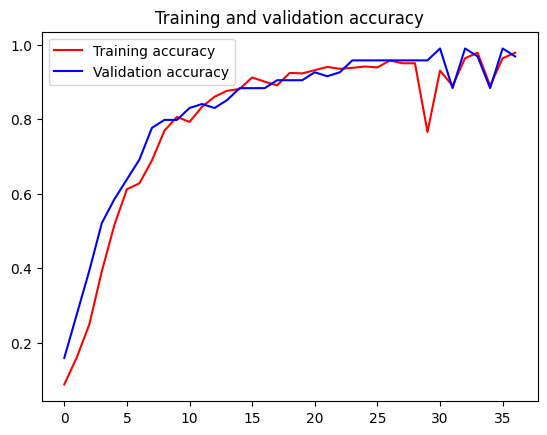

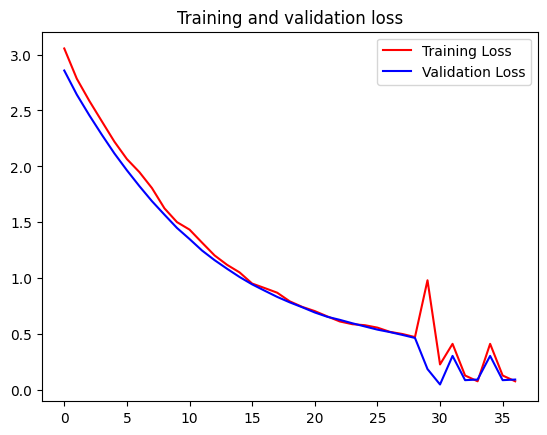

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'dataset' is already defined with accuracy and loss values
acc = dataset['accuracy']
val_acc = dataset['val_accuracy']
loss = dataset['loss']
val_loss = dataset['val_loss']

epochs = range(len(acc))

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Save the accuracy plot
plt.savefig('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/training_history_accuracy.png')

# Create a new figure for the loss plot
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

# Save the loss plot
plt.savefig('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/training_history_loss.png')

# Display both plots
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(testing_generator, verbose=1)

# Print evaluation results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.9470 - loss: 0.4825
Test Accuracy: 0.9565
Test Loss: 0.4901


In [ ]:
# Save the entire model to a .h5 file
model.save('/content/drive/Shared drives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/final_model_2.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


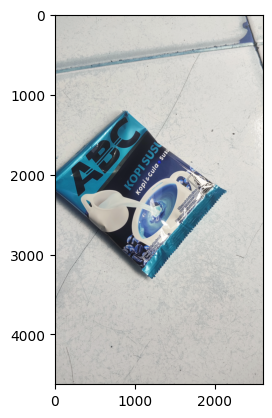

Image IMG_20241207_115408.jpg:
  Predicted class 1: ABC-Kopi-Susu-30g, Probability: 27.95%
  Predicted class 2: Kapal-Api-Signature-25g, Probability: 20.14%
  Predicted class 3: Tango-Royal-Chocolate-35g, Probability: 11.78%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


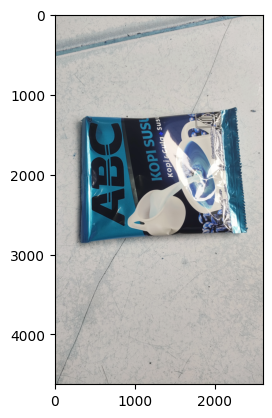

Image IMG_20241207_115422.jpg:
  Predicted class 1: ABC-Kopi-Susu-30g, Probability: 68.25%
  Predicted class 2: Ultra-Milk-Coklat-125ml, Probability: 5.45%
  Predicted class 3: Luwak-White-Coffee-20g, Probability: 4.25%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


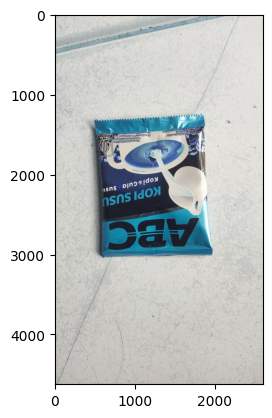

Image IMG_20241207_115452.jpg:
  Predicted class 1: ABC-Kopi-Susu-30g, Probability: 55.95%
  Predicted class 2: Luwak-White-Coffee-20g, Probability: 6.87%
  Predicted class 3: Indomie-Goreng-72g, Probability: 5.56%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


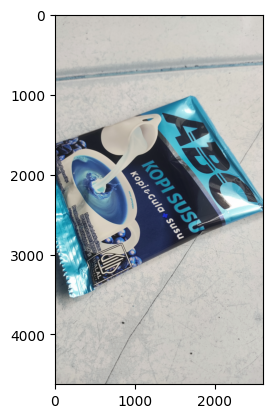

Image IMG_20241207_115524.jpg:
  Predicted class 1: ABC-Kopi-Susu-30g, Probability: 63.66%
  Predicted class 2: Luwak-White-Coffee-20g, Probability: 6.37%
  Predicted class 3: Kapal-Api-Signature-25g, Probability: 5.80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


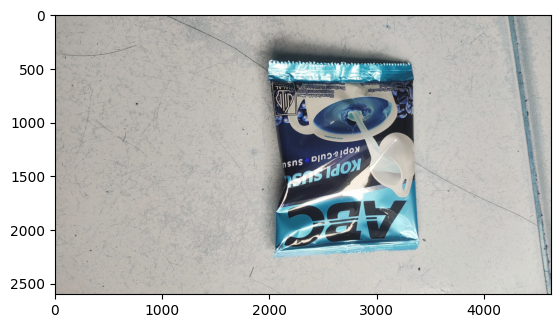

Image IMG_20241207_115358.jpg:
  Predicted class 1: ABC-Kopi-Susu-30g, Probability: 74.78%
  Predicted class 2: Kapal-Api-Signature-25g, Probability: 3.72%
  Predicted class 3: Energen-Cokelat-34g, Probability: 2.98%


In [ ]:

import os
import cv2
import numpy as np
import tensorflow as tf

top_n = 3

# Load trained model
model = tf.keras.models.load_model('/content/drive/Shareddrives/Capstone_Product/Fooddrink.dataset/model_checkpoints_2/final_model_2.h5')

# Path to the folder containing images for prediction
folder_path = "/content/drive/Shareddrives/Capstone_Product/Fooddrink.dataset/test_2/ABC-Kopi-Susu-30g"

# Loop through each image in the folder
for filename in os.listdir(folder_path):
    img = cv2.imread(os.path.join(folder_path, filename))
    # Resize the image to match the input size of model
    resize = tf.image.resize(img, (224, 224))
    # Normalize pixel values to [0, 1]
    input_data = np.expand_dims(resize / 255, 0)
    # Make predictions
    predictions = model.predict(input_data)
    plt.imshow(img)
    plt.show()

    class_names = list(train_generator.class_indices.keys())

    # Get the top N predictions
    top_n_indices = np.argsort(predictions[0])[::-1][:top_n]  # Get indices of top N classes
    top_n_classes = [class_names[i] for i in top_n_indices]
    top_n_probabilities = [predictions[0][i] * 100 for i in top_n_indices]

    print(f"Image {filename}:")
    for i in range(top_n):
        print(f"  Predicted class {i+1}: {top_n_classes[i]}, Probability: {top_n_probabilities[i]:.2f}%")

